## 1. Introduction

In this kernel, I would like to show some descriptive analysis of 'Olist Store' from Brazil. This data contains 100k orders information between 2016-2018.

Above analysis made by orders, geolocation, payments, seller, and products datasets. The aim of this project is finding the Top 10 products and sellers, analysis of orders by their geolocation and obtain information about Brazilian's online e-commerce profiles. 


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

## 2. Geo Exploratory

In [2]:
geo_data = pd.read_csv('../input/brazilian-ecommerce/olist_geolocation_dataset.csv')

In [3]:
geo_data.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [4]:
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap

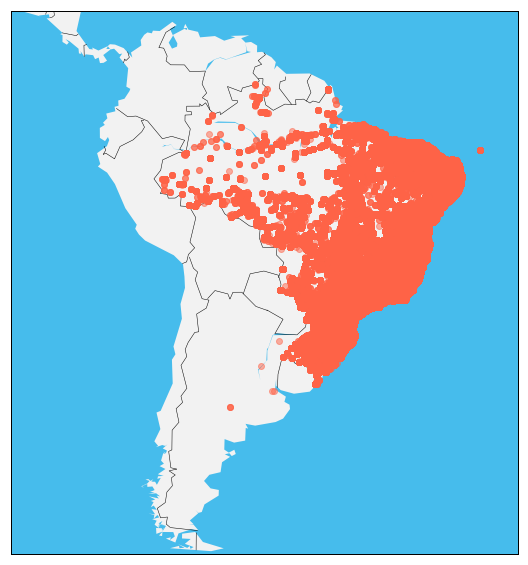

In [5]:
lat = geo_data['geolocation_lat']
lon = geo_data['geolocation_lng']

plt.figure(figsize=(10,10))

m = Basemap(llcrnrlat=-55.401805,llcrnrlon=-92.269176,urcrnrlat=13.884615,urcrnrlon=-27.581676)
m.bluemarble()
m.drawmapboundary(fill_color='#46bcec') # Make your map into any style you like
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec') # Make your map into any style you like
#m.drawcoastlines()
m.drawcountries()
m.scatter(lon, lat,zorder=10,alpha=0.5,color='tomato')

When we examine the population of Brazil, most of the population lived on the east coast and the small part is living more west side. Details about the population can be found on that web site: http://worldpopulationreview.com/countries/brazil-population/#popDensityMap.

Above map shows the location of purchased product orders and according to the distribution of populations, it explains the highest shopping rate on the east coast. 

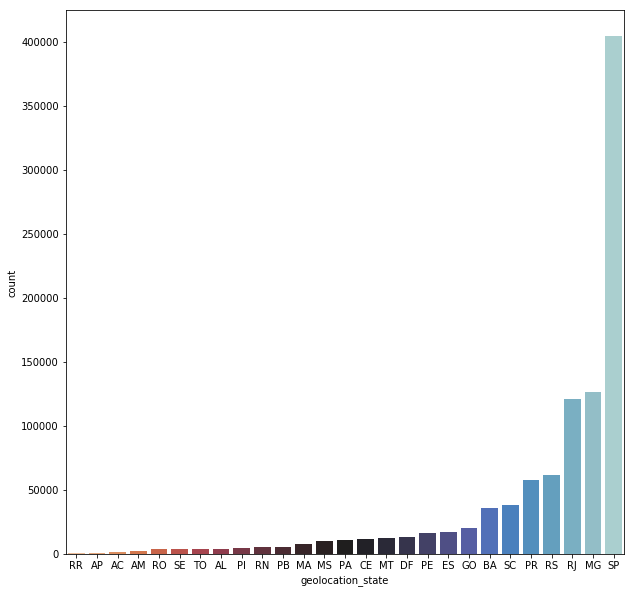

In [6]:
plt.figure(figsize=(10,10))
sns.countplot(x ='geolocation_state', data=geo_data, 
              order=geo_data['geolocation_state'].value_counts().sort_values().index, 
              palette='icefire_r')

The above graph shows the number of product orders purchased based on the states. According to that, São Paulo has the highest rate and there is a huge gap between the rest of the states.

## 3. Data Exploratory

### 3.1. Order Data

In [7]:
order_data = pd.read_csv('../input/brazilian-ecommerce/olist_orders_dataset.csv')

In [8]:
order_data.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

### 3.1.1. Feature Enginering with Time

Since, missing values' proportion is around 3%, Null Values from ``customer date`` feature will be filled with forward-fill method. This method, propagate the previous value forward

In [9]:
order_data['order_delivered_customer_date']= order_data['order_delivered_customer_date'].fillna(method='ffill')
order_data['order_delivered_customer_date'].isnull().sum()

0

``Delivered time`` and ``Estimate time`` features will be created.

In [10]:
order_data['delivered_time']=pd.to_datetime(order_data['order_delivered_customer_date'],
                                            format='%Y-%m-%d').dt.date
order_data['estimate_time']=pd.to_datetime(order_data['order_estimated_delivery_date'], 
                                           format='%Y-%m-%d').dt.date

``Weekly`` feature created based on ``order delivered customer date``

In [11]:
order_data['weekly']=pd.to_datetime(order_data['order_delivered_customer_date'],
                                    format='%Y-%m-%d').dt.week

``Yearly`` feature created based on ``order delivered customer date``

In [12]:
order_data['yearly']=pd.to_datetime(order_data['order_delivered_customer_date'])\
                    .dt.to_period('M')
order_data['yearly']= order_data['yearly'].astype(str)

Finding different days of delivered and estimated times.

In [13]:
order_data['diff_days']= order_data['delivered_time']-order_data['estimate_time']
order_data['diff_days']= order_data['diff_days'].dt.days

Text(0.5, 1.0, 'Average Difference Days per Week')

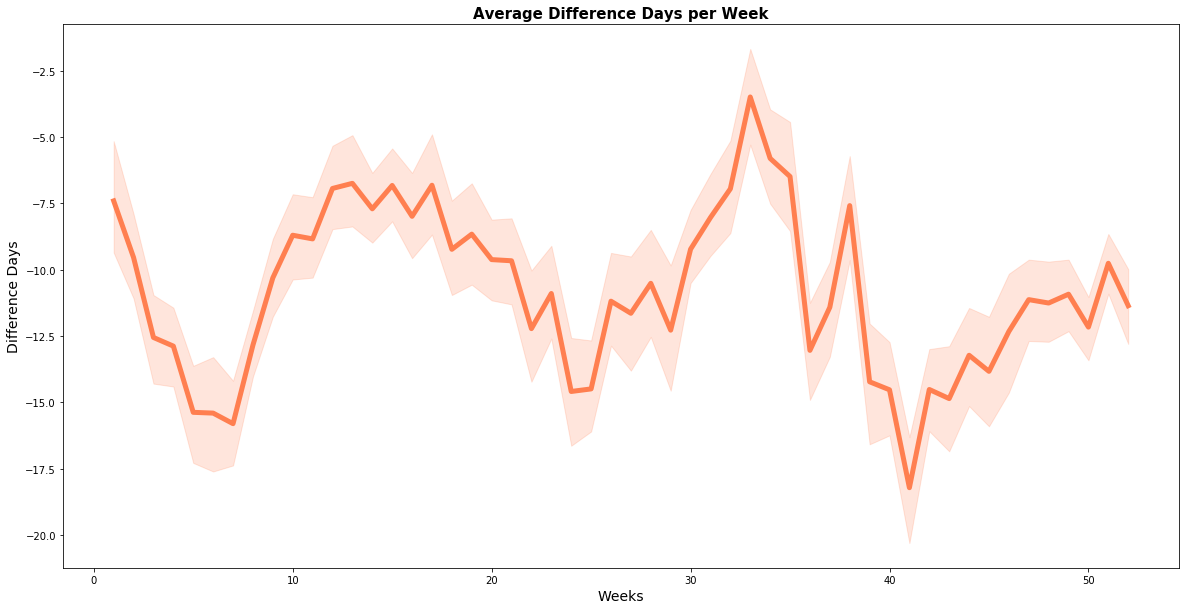

In [14]:
plt.figure(figsize=(20,10))
sns.lineplot(x='weekly', y='diff_days', data=order_data, color="coral", linewidth=5,
            markers=True,dashes=False, estimator='mean')

plt.xlabel("Weeks", size=14)
plt.ylabel("Difference Days", size=14)
plt.title("Average Difference Days per Week",size=15, weight='bold')

Above graph shows that the earliest and latest deliveries. According to that, we can say that all deliveries made before their estimated date. 
* The earliest deliveries have been made in October. It means that this month is the least intensive period in those years.
* Latest deliveries have been made at the end of June and beginning of August. It means that this time is the most intensive period in those years.

## 3.2. Customer Top 10 Product

First, Olist_orders and olist_order_items databases will be joined.

In [15]:
# Upload Olist_Order_Items and Product Data
order_item_data = pd.read_csv('../input/brazilian-ecommerce/olist_order_items_dataset.csv')
products_data = pd.read_csv('../input/brazilian-ecommerce/olist_products_dataset.csv')

In [16]:
#Merge data
total_orders=pd.merge(order_data, order_item_data)
product_orders=pd.merge(total_orders,products_data, on="product_id")
product_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 27 columns):
order_id                         112650 non-null object
customer_id                      112650 non-null object
order_status                     112650 non-null object
order_purchase_timestamp         112650 non-null object
order_approved_at                112635 non-null object
order_delivered_carrier_date     111456 non-null object
order_delivered_customer_date    112650 non-null object
order_estimated_delivery_date    112650 non-null object
delivered_time                   112650 non-null object
estimate_time                    112650 non-null object
weekly                           112650 non-null int64
yearly                           112650 non-null object
diff_days                        112650 non-null int64
order_item_id                    112650 non-null int64
product_id                       112650 non-null object
seller_id                        112650 non-null obj

Since the ``product_id`` value name is long, it needed to be shortened to make an analysis. With taking the last eight characters, uniqueness preserved. 

In [17]:
len(product_orders['product_id'].unique())

32951

In [18]:
len(product_orders['product_id'].str[-8:].unique())

32951

In [19]:
product_orders['product_id_shorten']=product_orders['product_id'].str[-8:]

Text(0.5, 1.0, 'Top 10 Products')

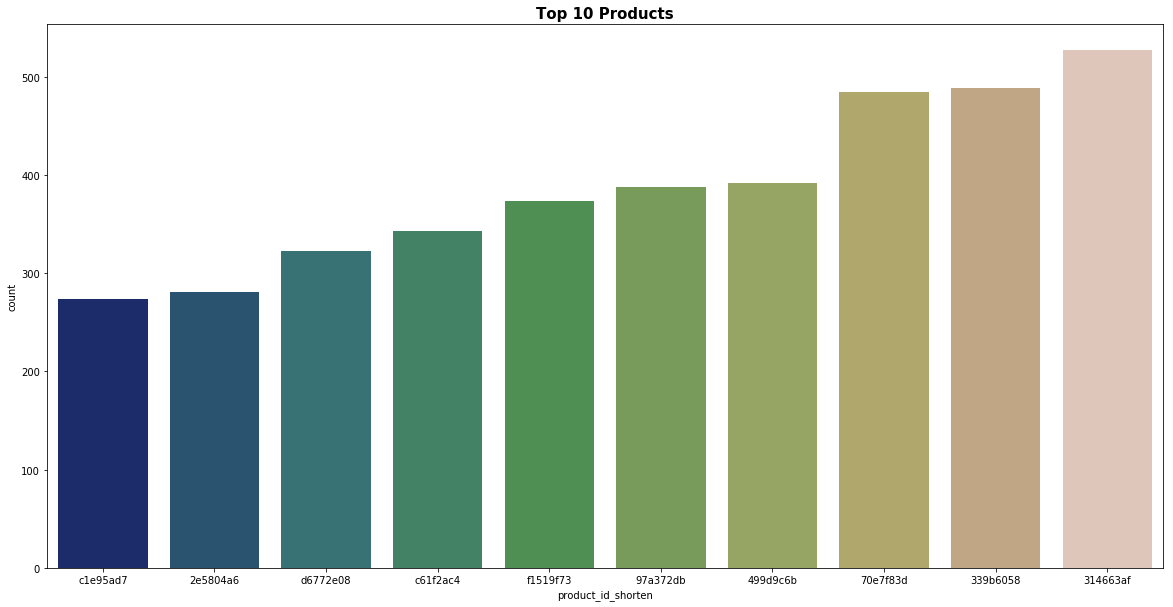

In [20]:
#Plotting Top 10 Products
plt.figure(figsize=(20,10))
sns.countplot(x='product_id_shorten', data=product_orders, palette='gist_earth',
             order=product_orders['product_id_shorten'].value_counts()[:10]\
             .sort_values().index).set_title("Top 10 Products", fontsize=15,
                                             weight='bold')

The above graph shows the Top 10 products. Top 3 products have a significant difference from the others. Because of the data information, we can't say about what are these products. But we can assume about their category.

First Top 10 products' category shown below the table. According to the table, ``bed_table_bath`` orders have the highest one.

In [21]:
product_orders.groupby(["product_category_name"])["product_id_shorten"].count().sort_values(ascending=False).head(10)

product_category_name
cama_mesa_banho           11115
beleza_saude               9670
esporte_lazer              8641
moveis_decoracao           8334
informatica_acessorios     7827
utilidades_domesticas      6964
relogios_presentes         5991
telefonia                  4545
ferramentas_jardim         4347
automotivo                 4235
Name: product_id_shorten, dtype: int64

In [22]:
group_category= product_orders.groupby(['product_id_shorten','product_category_name',])['product_id_shorten']\
                                        .count().sort_values(ascending=False).head(10)
group_category

product_id_shorten  product_category_name 
314663af            moveis_decoracao          527
339b6058            cama_mesa_banho           488
70e7f83d            ferramentas_jardim        484
499d9c6b            ferramentas_jardim        392
97a372db            ferramentas_jardim        388
f1519f73            ferramentas_jardim        373
c61f2ac4            informatica_acessorios    343
d6772e08            relogios_presentes        323
2e5804a6            beleza_saude              281
c1e95ad7            informatica_acessorios    274
Name: product_id_shorten, dtype: int64

Despite the top product category of ``bed_table_bath``, the top ordered product's category is a ``home decoration``. 

## 3.3. Top 10 Seller

In [23]:
sellers_data = pd.read_csv('../input/brazilian-ecommerce/olist_sellers_dataset.csv')

First ``seller`` dataset will be merged with the ``product orders`` data.

In [24]:
seller_products = pd.merge(product_orders, sellers_data, on="seller_id")
seller_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 31 columns):
order_id                         112650 non-null object
customer_id                      112650 non-null object
order_status                     112650 non-null object
order_purchase_timestamp         112650 non-null object
order_approved_at                112635 non-null object
order_delivered_carrier_date     111456 non-null object
order_delivered_customer_date    112650 non-null object
order_estimated_delivery_date    112650 non-null object
delivered_time                   112650 non-null object
estimate_time                    112650 non-null object
weekly                           112650 non-null int64
yearly                           112650 non-null object
diff_days                        112650 non-null int64
order_item_id                    112650 non-null int64
product_id                       112650 non-null object
seller_id                        112650 non-null obj

As the ``product id`` value name, the ``seller id`` name needed to be shortened. 

In [25]:
len(seller_products['seller_id'].unique())

3095

In [26]:
len(seller_products['seller_id'].str[-6:].unique())

3095

In [27]:
seller_products['seller_id_shorten']=seller_products['seller_id'].str[-6:]

Below pie chart shows the Top 10 Seller. First 3 sellers have close proportions.

Text(0.5, 1.0, 'Top 10 Seller')

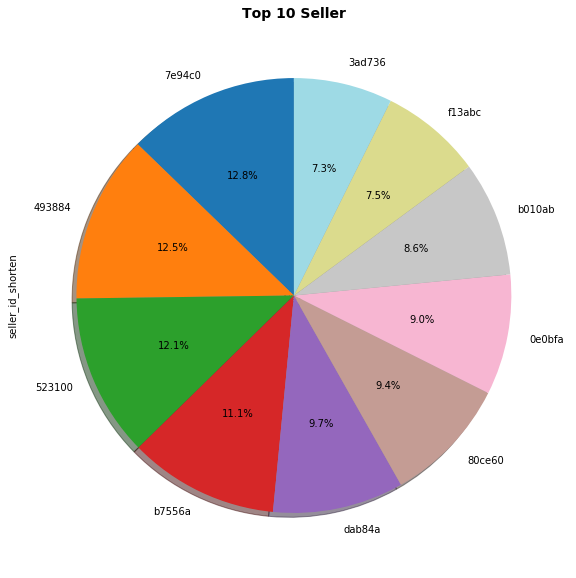

In [28]:
plt.figure(figsize=(20,10))
seller_products['seller_id_shorten'].value_counts()[:10].plot.pie(autopct='%1.1f%%',
        shadow=True, startangle=90, cmap='tab20')
plt.title("Top 10 Seller",size=14, weight='bold')

Assuming for the orders' product category of these sellers, we can use 'product category' values. Below table shows the Top 10 sellers category, and since they can sell multiple product types, garden tools are the most selling product of the best seller. 

In [29]:
seller_category= seller_products.groupby(['seller_id_shorten', 'product_category_name'])\
                        ['seller_id_shorten'].count().sort_values(ascending=False).head(10)
seller_category

seller_id_shorten  product_category_name
523100             ferramentas_jardim       1882
7e94c0             relogios_presentes       1628
493884             cama_mesa_banho          1572
0e0bfa             moveis_decoracao         1292
dab84a             cama_mesa_banho          1277
b010ab             moveis_escritorio        1233
f13abc             telefonia                1178
b7556a             beleza_saude             1091
3ad736             cool_stuff               1069
3b52b2             relogios_presentes       1002
Name: seller_id_shorten, dtype: int64

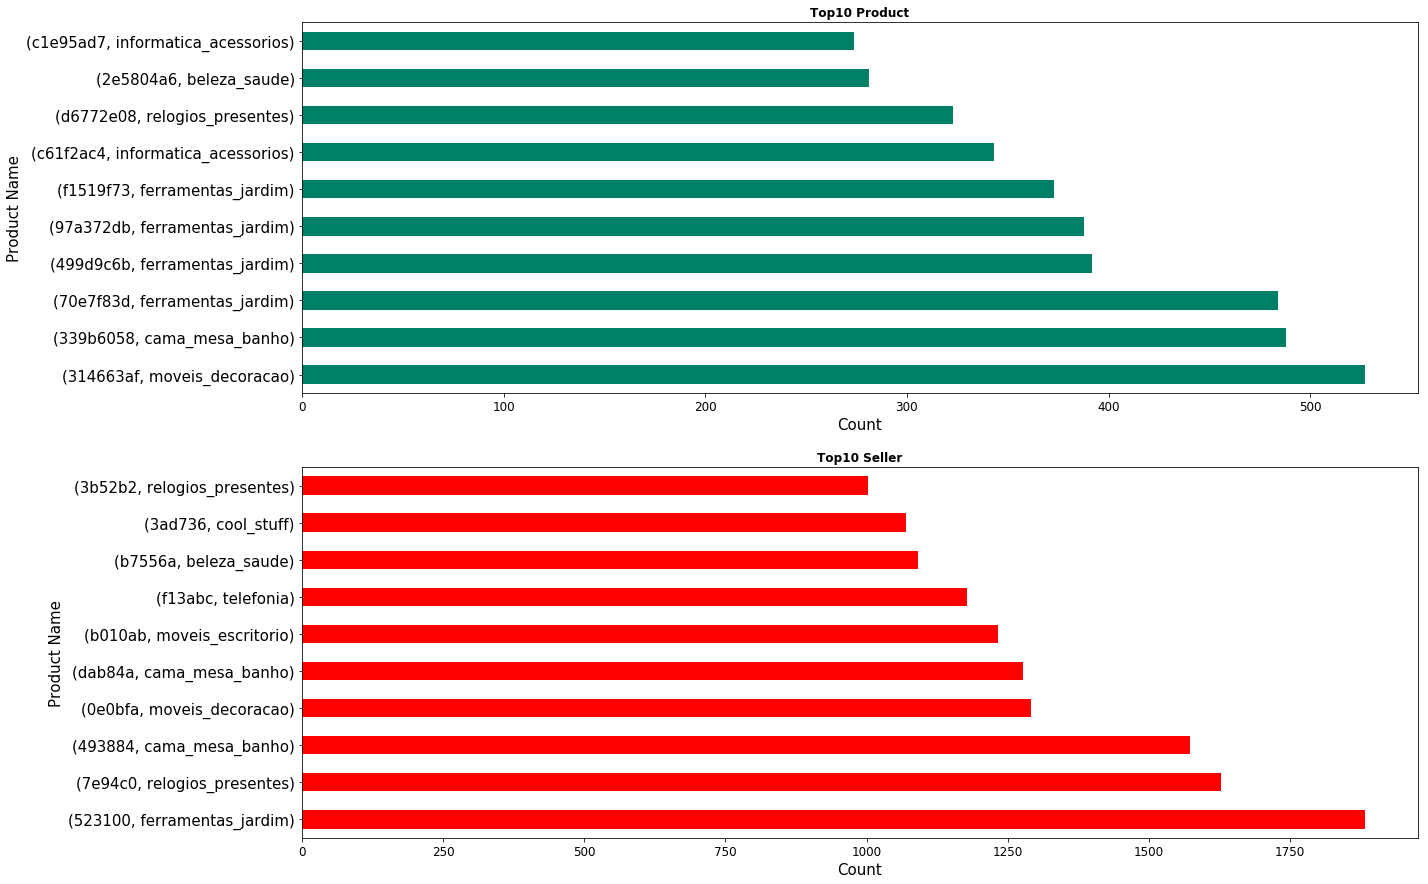

In [30]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,15))
group_category.plot.barh(ax=ax1, cmap='summer')
seller_category.plot.barh(ax=ax2, cmap='autumn')

ax1.set_title('Top10 Product', fontweight='bold')
ax2.set_title('Top10 Seller', fontweight='bold')

ax1.set_xlabel('Count', fontsize=15)
ax1.set_ylabel('Product Name', fontsize=15)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=15)

ax2.set_xlabel('Count', fontsize=15)
ax2.set_ylabel('Product Name', fontsize=15)
ax2.xaxis.set_tick_params(labelsize=12)
ax2.yaxis.set_tick_params(labelsize=15)

Above graphs show the top products and top sellers category. While most selling product item belongs to the home decoration, most seller item belongs to garden tools.

Now, we can examine the most selling product's weekly purchased numbers, which is ``314663af`` and belong to ``home decoration``.

In [31]:
# First creating new feature of weeks
product_orders['order_week']= pd.to_datetime(product_orders['order_purchase_timestamp'],
                                            format='%Y-%m-%d').dt.week

Below graph shows the weekly purchased number of ``314663af``. According to that, the least purchased months are June and August. In the rest of the months, at least one week is the highest purchase of those months. 

Text(0.5, 1.0, 'Weekly Purchased Number of `314663af`')

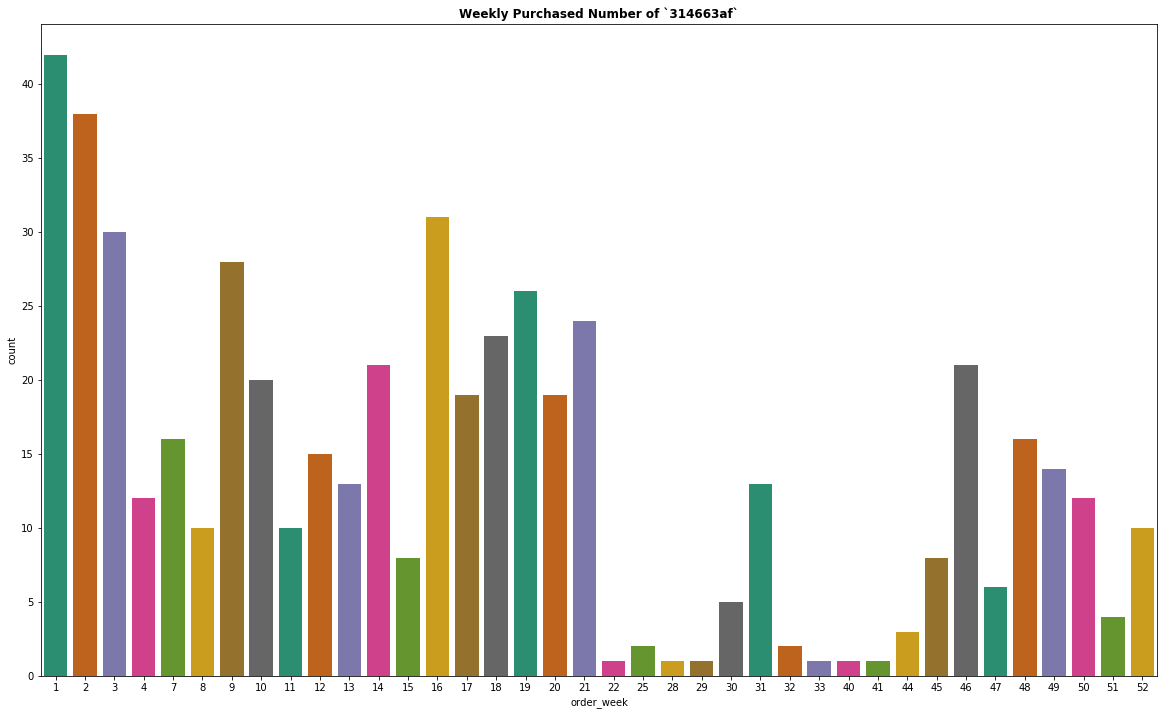

In [32]:
plt.figure(figsize=(20,12))
sns.countplot('order_week', data=product_orders[product_orders['product_id_shorten']== 
                                        '314663af'], palette='Dark2', linewidth=5)\
                                        .set_title('Weekly Purchased Number of `314663af`'
                                                   ,fontweight='bold')


Now instead of the most selling ordered product, we can examine the most selling product category by weekly. 

In [33]:
#Weekly popular items 
items_weekly =product_orders.groupby(['order_week','product_category_name'])\
                        ['product_category_name'].count().sort_values(ascending=False)
#Change to data frame
most_products= items_weekly.reset_index(name='count')

In [34]:
#Find the max value of row
max_selling_products= most_products[most_products['count'] 
                            == most_products.groupby(['order_week'])\
                            ['count'].transform(max)]
max_selling_products.head(10)

,order_week,product_category_name,count
0,47,cama_mesa_banho,438
2,33,cama_mesa_banho,355
3,29,cama_mesa_banho,339
4,8,informatica_acessorios,330
5,32,beleza_saude,330
8,31,beleza_saude,320
9,9,informatica_acessorios,314
10,19,beleza_saude,310
11,18,beleza_saude,302
12,23,cama_mesa_banho,301


In [35]:
max_selling_products['product_category_name'].value_counts()

cama_mesa_banho           33
beleza_saude              10
esporte_lazer              3
informatica_acessorios     3
moveis_decoracao           2
brinquedos                 1
Name: product_category_name, dtype: int64

Above table shows that 33 of 52 weeks the most selling's product is ``bed_table_bath``. This category is in the top 3 either most selling product group or most sellers group. 

## 3.3. Payments 
Last data exploratory is about payments. 

In [36]:
payment_data = pd.read_csv('../input/brazilian-ecommerce/olist_order_payments_dataset.csv')

In [37]:
payments=pd.merge(seller_products, payment_data, on="order_id")
payments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117601 entries, 0 to 117600
Data columns (total 36 columns):
order_id                         117601 non-null object
customer_id                      117601 non-null object
order_status                     117601 non-null object
order_purchase_timestamp         117601 non-null object
order_approved_at                117586 non-null object
order_delivered_carrier_date     116356 non-null object
order_delivered_customer_date    117601 non-null object
order_estimated_delivery_date    117601 non-null object
delivered_time                   117601 non-null object
estimate_time                    117601 non-null object
weekly                           117601 non-null int64
yearly                           117601 non-null object
diff_days                        117601 non-null int64
order_item_id                    117601 non-null int64
product_id                       117601 non-null object
seller_id                        117601 non-null obj

In [38]:
#First drop irrelevant columns that to make more handy to data
payments= payments.drop(columns=['product_name_lenght','product_description_lenght',
                                 'product_photos_qty','product_weight_g','product_length_cm',
                                 'product_height_cm','product_width_cm'])

In [39]:
price_details= payments.groupby(['order_id','price','product_category_name',
                                 'yearly','weekly'])[['freight_value','payment_value']].sum().reset_index()

As written on the data description, ``total order value`` can be calculated by sum of ``price`` and ``freight value``.

In [40]:
price_details['total_order_value'] = price_details['price'] + price_details['freight_value']

We can calculate ``Gross Profit`` and ``Profit Margin`` by ``payment value`` and ``total order value``

In [41]:
price_details['gross_profit'] = price_details['payment_value']- price_details['total_order_value']
price_details['profit_margin'] = price_details['gross_profit']/price_details['payment_value']
price_details['profit_margin'] = price_details['profit_margin'].astype('int64')

In [42]:
price_details.sort_values('gross_profit', ascending=False).head(10)

,order_id,price,product_category_name,yearly,weekly,freight_value,payment_value,total_order_value,gross_profit,profit_margin
1466,03caa2c082116e1d31e67e9ae3700499,1680.00,telefonia_fixa,2017-10,42,224.08,109312.64,1904.08,107408.56,0
66523,ab14fdcfbe524636d65ee38360e22ce8,98.70,automotivo,2017-09,35,288.80,45256.00,387.50,44868.50,0
10548,1b15974a0141d54e36626dca3fdc731a,100.00,informatica_acessorios,2018-03,10,202.40,44048.00,302.40,43745.60,0
17262,2cc9089445046817a7539d90805e6e5a,989.10,agro_industria_e_comercio,2017-12,50,146.94,36489.24,1136.04,35353.20,0
90941,e8fa22c3673b1dd17ea315021b1f0f61,284.99,bebidas,2018-05,18,168.70,30186.00,453.69,29732.31,0
44991,736e1922ae60d0d6a89247b851902527,1790.00,telefonia_fixa,2018-07,30,114.88,29099.52,1904.88,27194.64,0
25844,428a2f660dc84138d969ccd69a0ab6d5,65.49,moveis_decoracao,2017-12,50,243.30,18384.75,308.79,18075.96,0
22593,3a213fcdfe7d98be74ea0dc05a8b31ae,108.00,relogios_presentes,2018-01,4,186.24,17786.88,294.24,17492.64,0
96747,f80549a97eb203e1566e026ab66f045b,137.90,informatica_acessorios,2017-09,39,388.10,17671.00,526.00,17145.00,0
26447,4412d97cb2093633afa85f11db46316c,120.00,informatica_acessorios,2018-06,23,83.99,15978.65,203.99,15774.66,0


Text(0.5, 1.0, 'Gross Profit of Top 5 Products (2016-2018)')

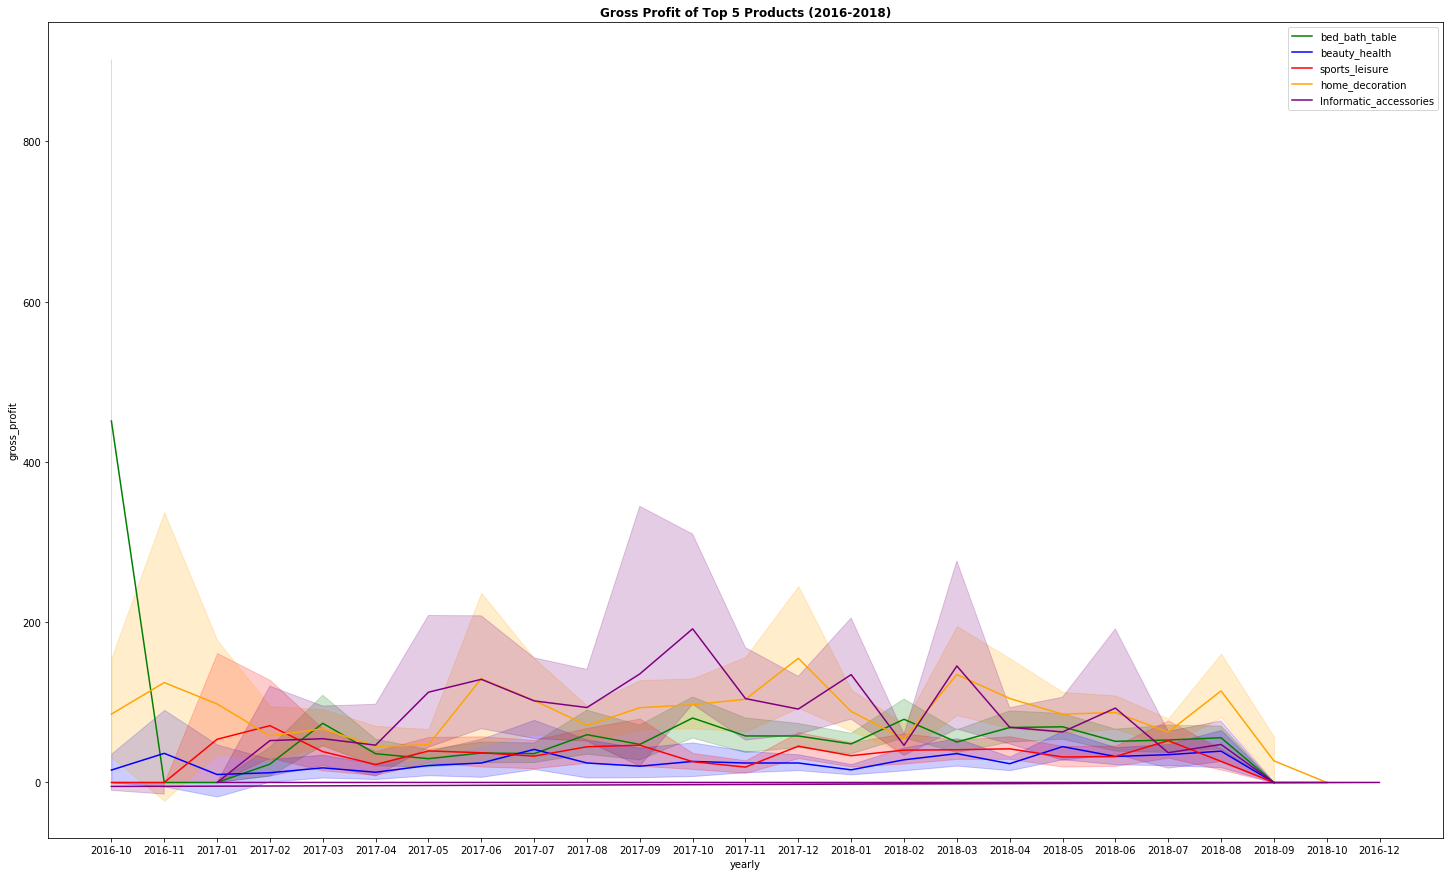

In [43]:
plt.figure(figsize=(25,15))

sns.lineplot(x='yearly',y='gross_profit',
             data=price_details[price_details['product_category_name']\
             =='cama_mesa_banho'], label='bed_bath_table',color="green")
sns.lineplot(x='yearly', y='gross_profit',
             data=price_details[price_details['product_category_name']\
             =='beleza_saude'], label='beauty_health', color="blue")
sns.lineplot(x='yearly', y='gross_profit',
             data=price_details[price_details['product_category_name']\
             =='esporte_lazer'], label='sports_leisure', color="red")
sns.lineplot(x='yearly', y='gross_profit',
             data=price_details[price_details['product_category_name']\
             =='moveis_decoracao'], label='home_decoration', color="orange")
sns.lineplot(x='yearly', y='gross_profit',
             data=price_details[price_details['product_category_name']\
             =='informatica_acessorios'], label='Informatic_accessories', color="purple")
plt.title("Gross Profit of Top 5 Products (2016-2018)",fontweight='bold')

Above graph shows yearly 'gross profit' distribution for the top 5 product category of ordered products and sellers. According to data, we can say that ``informatic_accessories`` have the highest gross profit in Agust 2017 to November 2017. On the other hand, the top 3 products which are ``bed_bath_table``, ``beauty_health`` and ``sports_leisure``, gross profits are less than 200 units of currency.

## 4. CONCLUCION

In this project, I wanted to show Brazilian online shoppers' some general profile based on product category, time, etc. I hope it would help other people who want to deal with this dataset.

Any comments and feedback are welcomed.